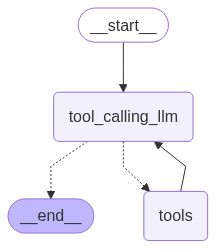

{'messages': [SystemMessage(content='You are helpfull assistant', additional_kwargs={}, response_metadata={}, id='8a0a003c-c74f-4cd5-b679-71f1ae4323bd'),
  HumanMessage(content='Hello, how do you do?', additional_kwargs={}, response_metadata={}, id='feb9c30e-4a93-4c9d-8101-8e9d1cd233f5'),
  AIMessage(content="Hello! I'm here to help you with any questions or information you need. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 83, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BlwZA955pXDiqHZcQFz3DFBGVFh7p', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d3ad939a-3b6e-49ab-bfd9-692d38fd6878-0',

In [4]:
from typing import Annotated, Literal
import random
from IPython.display import Image, display
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from src.config import settings


# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

config = {"configurable": {"thread_id": "1"}}
sys_msg = SystemMessage(content="You are helpfull assistant")

memory = MemorySaver()


class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]


@tool
def count_words(query: str) -> int:
    """Return the number of words in the user's message."""
    return len(query.split())


@tool
def is_question(query: str) -> bool:
    """Return True if the message is a question."""
    return query.strip().endswith("?")


async def tool_calling_llm(state: State) -> dict:
    ai_response = await llm.ainvoke(state.messages, config=config)
    return {"messages": state.messages + [ai_response]}


tools = [count_words, is_question]
llm = llm.bind_tools(tools)

builder = StateGraph(State)
builder.add_node(tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, tool_calling_llm.__name__)
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", tool_calling_llm.__name__)
builder.add_edge(tool_calling_llm.__name__, END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))
msg = await graph.ainvoke(
    {"messages": [sys_msg] + [HumanMessage("Hello, how do you do?")]}, config=config
)
msg = await graph.ainvoke(
    {"messages": [HumanMessage("wahts your name")]}, config=config
)
msg

In [31]:
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")
assistants = await client.assistants.search()
assistants

[{'assistant_id': 'f367d8bf-9aa2-5c60-a4b7-6b017b9bd1dd',
  'graph_id': 'my_graph',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'my_graph',
  'created_at': '2025-06-20T10:18:52.103840+00:00',
  'updated_at': '2025-06-20T10:18:52.103840+00:00',
  'version': 1,
  'description': None}]

In [ ]:
from typing import Annotated, Literal
import random
from IPython.display import Image, display
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
    AIMessage,
    AnyMessage,
    RemoveMessage,
)
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from src.config import settings


# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

config = {"configurable": {"thread_id": "2"}}

memory = MemorySaver()


class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    summary: str = ""


async def llm_response(state: State):
    query = []
    if state.summary:
        query.append(
            SystemMessage(
                f"You are continuing a conversation. Here is a summary of the earlier messages with the user: {state.summary}. "
                f"Pay attention to the summary and treat it as your memory of the conversation and answer to user accroding to this summary. "
                f"Below is the newest messages from the user:\n"
            )
        )
    query.extend(state.messages)
    response = await llm.ainvoke(query, config=config)
    return {"messages": state.messages + [response]}


async def summarize_history(state: State) -> dict:
    current_summary = state.summary
    query = []
    if current_summary:
        query.append(
            SystemMessage(
                f"Here is the current conversation summary:\n{current_summary}\n\n"
                "Based on the new messages above, extend and update the summary. "
                "Keep the overall context in mind, including any personal details or user-specific information shared earlier (e.g., name, background, preferences). "
                "Keep the updated summary brief and focused. "
                f"Ignore meta-dialogue like requests to summarize, greetings, or confirmations."
            )
        )
    else:
        query.append(
            SystemMessage(
                f"Provide the summary of the conversation above. "
                f"Remeber overrall content of conversation and user details, personal information, name etc. "
                f"keep summary short."
                f"Message history:\n"
            )
        )

    query = state.messages + query
    summary = await llm.ainvoke(query, config=config)
    return {
        "messages": [RemoveMessage(id=msg.id) for msg in state.messages[:-2]],
        "summary": summary.content,
    }


def should_continue(state: State) -> str:
    if len(state.messages) > 3:
        return "summarize_history"
    return END


builder = StateGraph(State)
builder.add_node(llm_response)
builder.add_node(summarize_history)

builder.add_edge(START, llm_response.__name__)
builder.add_conditional_edges(
    llm_response.__name__,
    should_continue,
    {
        "summarize_history": summarize_history.__name__,
        END: END,
    },
)
builder.add_edge(summarize_history.__name__, END)

graph = builder.compile(checkpointer=memory)
# display(Image(graph.get_graph().draw_mermaid_png()))
msg = await graph.ainvoke(
    {"messages": [HumanMessage("Hello, how do you do?, My name is Jim")]}, config=config
)
msg = await graph.ainvoke(
    {"messages": [HumanMessage("wahts your name")]}, config=config
)
msg = await graph.ainvoke(
    {"messages": [HumanMessage("Can you speak egyptian?")]}, config=config
)
# msg = await graph.ainvoke({"messages": [HumanMessage("whats my name?")]}, config=config)
async for event in graph.astream_events(
    {"messages": [HumanMessage("whats my name?")]}, config=config, stream_mode="values"
):
    if event["event"] == "on_chat_model_stream":
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--3a6628be-6f37-4f6d-8cdf-90fbafaf9b73')}
{'chunk': AIMessageChunk(content='Your', additional_kwargs={}, response_metadata={}, id='run--3a6628be-6f37-4f6d-8cdf-90fbafaf9b73')}
{'chunk': AIMessageChunk(content=' name', additional_kwargs={}, response_metadata={}, id='run--3a6628be-6f37-4f6d-8cdf-90fbafaf9b73')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run--3a6628be-6f37-4f6d-8cdf-90fbafaf9b73')}
{'chunk': AIMessageChunk(content=' Jim', additional_kwargs={}, response_metadata={}, id='run--3a6628be-6f37-4f6d-8cdf-90fbafaf9b73')}
{'chunk': AIMessageChunk(content='.', additional_kwargs={}, response_metadata={}, id='run--3a6628be-6f37-4f6d-8cdf-90fbafaf9b73')}
{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'service_tier': 'default'}

RuntimeError: asyncio.run() cannot be called from a running event loop